# Hyper-parameter tuning – Friedman #3 Dataset  
This notebook finds the best parameters for:

* **Bagging** RandomForestRegressor  
* **Boosting** XGBRegressor  
* **Stack meta learner** Ridge α in the RF+XGB+OLS stack

Results are saved to `configs/` folder as yaml files.

## Setup & Imports

In [ ]:
from joblib import parallel_backend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.model_selection import (
    RepeatedKFold,
    KFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.visualization import plot_optimization_history

from bagging_boosting_stacking_study.constants import SEED
from bagging_boosting_stacking_study.data.loaders import load_dataset
from bagging_boosting_stacking_study.configs import save_params, load_params

DATASET_NAME = "airfoil_self_noise"

In [2]:
# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

## Load Clean Dataset

In [3]:
df = load_dataset(DATASET_NAME, raw=False)

### train test split

In [4]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)

In [5]:
train_df.shape

(1171, 13)

In [6]:
test_df.shape

(131, 13)

## Bagging

### pipeline



### hyper-parameter tuning

In [7]:
# Split X and y (here X is a DataFrame -- needed for preprocessing in study)
y = train_df["target"].values
X = train_df.drop(columns="target")
n_features_total = X.shape[1]

# Cross-validation strategy: 10-fold, repeated three times
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)


# Objective function for Optuna
def objective(trial):
    # Hyper-parameter search space

    # (a) Ensemble size: enough trees to stabilise predictions; >600 rarely helps here.
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 400, 600])

    # (b) Tree depth: capped depth explores up to 10; 'None' lets the forest grow if CV
    # rewards it.
    if trial.suggest_categorical("cap_depth", [True, False]):
        max_depth = trial.suggest_int("max_depth", 4, 15)
    else:
        max_depth = None

    # (c) Split regularisation: avoid overly eager splitting on tiny groups.
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # (d) Feature subsampling: 2 -> forces interaction discovery from raw cols;
    # 11 -> lets trees see engineered ones.
    max_features = trial.suggest_int("max_features", 2, n_features_total)

    # (e) Row subsampling / bootstrap
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_samples = (
        trial.suggest_float("max_samples", 0.5, 1.0, step=0.1) if bootstrap else None
    )

    # (f) Impurity criterion & pruning
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "absolute_error"]
    )
    # Allow stronger cost-complexity pruning (1e-6 -> 1e-2) to tame deep trees.
    ccp_alpha = trial.suggest_float("ccp_alpha", 1e-6, 1e-2, log=True)

    # (g) OOB score (only valid if bootstrap)
    oob_score = bootstrap and trial.suggest_categorical("oob_score", [True, False])

    # Model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        max_samples=max_samples,
        criterion=criterion,
        ccp_alpha=ccp_alpha,
        oob_score=oob_score,
        n_jobs=-1,
        random_state=SEED,
    )

    # CV evaluation
    # NOTE: scikit-learn returns negative RMSE so I negate “neg_root_mean_squared_error”
    # again to get a positive value to minimise.
    rmse = -cross_val_score(
        rf, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the study
study_rf = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),  # reproducible search
    pruner=HyperbandPruner(),  # aggressive early stopping
    study_name=f"RF_{DATASET_NAME}",
)

# Robust search: either n_trials or timeout
study_rf.optimize(objective, n_trials=200, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

# Inspect the result
print("Best RMSE :", study_rf.best_value)
print("Best parameters:", study_rf.best_params)

[I 2025-05-26 18:32:39,758] A new study created in memory with name: RF_airfoil_self_noise


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-26 18:32:43,534] Trial 0 finished with value: 3.8333007927185756 and parameters: {'n_estimators': 200, 'cap_depth': True, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 11, 'bootstrap': False, 'criterion': 'squared_error', 'ccp_alpha': 4.990389950807067e-06}. Best is trial 0 with value: 3.8333007927185756.
[I 2025-05-26 18:32:53,486] Trial 1 finished with value: 2.85120946327453 and parameters: {'n_estimators': 600, 'cap_depth': True, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 2, 'bootstrap': True, 'max_samples': 1.0, 'criterion': 'absolute_error', 'ccp_alpha': 9.569896188350861e-06, 'oob_score': False}. Best is trial 1 with value: 2.85120946327453.
[I 2025-05-26 18:32:56,729] Trial 2 finished with value: 2.7120163649293856 and parameters: {'n_estimators': 100, 'cap_depth': True, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 12, 'bootstrap': True, 'max_samples': 0.5, 'criteri

In [8]:
fig = plot_optimization_history(study_rf)
fig.show()

In [9]:
print("Best RMSE :", study_rf.best_value)

Best RMSE : 1.5662031691098768


In [10]:
study_rf.best_params

{'n_estimators': 400,
 'cap_depth': False,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 11,
 'bootstrap': True,
 'max_samples': 1.0,
 'criterion': 'absolute_error',
 'ccp_alpha': 1.2167748107168915e-06,
 'oob_score': True}

In [11]:
# Save best params to .yaml
save_params(DATASET_NAME, "rf", study_rf.best_value, study_rf.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\airfoil_self_noise_rf.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/airfoil_self_noise_rf.yaml')

In [ ]:
# Retrieve Optuna's best run
best_rf_params = study_rf.best_params.copy()

cap_flag = best_rf_params.pop("cap_depth")  # True / False
max_depth = best_rf_params.pop("max_depth", None)  # may not exist
best_rf_params["max_depth"] = max_depth if cap_flag else None

best_rf_params.update(
    {
        "random_state": SEED,
        "n_jobs": -1,
    }
)

if not best_rf_params.get("bootstrap", False):
    # Optuna only logged these if bootstrap was True; make them explicit.
    best_rf_params["max_samples"] = None
    best_rf_params["oob_score"] = False

# Fit on the full training data
rf_final = RandomForestRegressor(**best_rf_params)
rf_final.fit(train_df.drop(columns="target"), train_df["target"])

RandomForestRegressor(ccp_alpha=1.2167748107168915e-06,
                      criterion='absolute_error', max_features=11,
                      max_samples=1.0, n_estimators=400, n_jobs=-1,
                      oob_score=True, random_state=333)

## Boosting

In [13]:
# Split X and y
y = train_df["target"].values
X = train_df.drop(columns="target")

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)


# Objective function
def objective(trial):
    # Search space

    # Ensemble size — >800 rarely helps with 180 rows
    n_estimators = trial.suggest_int("n_estimators", 50, 800, step=50)

    # Learning rate — allow slower (0.01) but not ultra-slow (0.001) to keep runtime sane
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)

    # Depth or leaf-based growth
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if grow_policy == "depthwise":
        max_depth = trial.suggest_int("max_depth", 3, 10)
        max_leaves = 0  # ignored
    else:  # lossguide (leaf-wise)
        max_depth = 0
        max_leaves = trial.suggest_int("max_leaves", 16, 128, step=16)  # small caps

    # Child-weight regularisation
    min_child_weight = trial.suggest_float("min_child_weight", 0.5, 10.0, log=True)

    # Row & column subsampling for variance control
    subsample = trial.suggest_float("subsample", 0.6, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1, step=0.1)

    # Regularisation terms
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 30.0, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 10.0)
    gamma = trial.suggest_float("gamma", 0.0, 5.0)  # min loss-reduction to split

    # A gentle safety knob; rarely fires in regression but costs nothing
    max_delta_step = trial.suggest_int("max_delta_step", 0, 5)

    # Build the Pipeline with XGB model
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        max_delta_step=max_delta_step,
        grow_policy=grow_policy,
        objective="reg:squarederror",
        tree_method="hist",
        random_state=SEED,
        n_jobs=-1,
    )

    # CV evaluation (neg RMSE -> minimise RMSE)
    rmse = -cross_val_score(
        xgb, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the Optuna study
study_xgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=HyperbandPruner(),  # stops weak configs early
    study_name=f"XGB_{DATASET_NAME}",
)

study_xgb.optimize(objective, n_trials=500, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

print("Best RMSE :", study_xgb.best_value)
print("Best parameters:", study_xgb.best_params)

[I 2025-05-26 18:53:52,558] A new study created in memory with name: XGB_airfoil_self_noise


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-05-26 18:53:54,792] Trial 0 finished with value: 1.6055402789700834 and parameters: {'n_estimators': 450, 'learning_rate': 0.119329717868809, 'grow_policy': 'lossguide', 'max_leaves': 48, 'min_child_weight': 0.5778492080094182, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_lambda': 0.012551637712518278, 'reg_alpha': 8.73489354458811, 'gamma': 0.2580581965137452, 'max_delta_step': 0}. Best is trial 0 with value: 1.6055402789700834.
[I 2025-05-26 18:53:55,640] Trial 1 finished with value: 1.8424793075560042 and parameters: {'n_estimators': 200, 'learning_rate': 0.019993480767036637, 'grow_policy': 'lossguide', 'max_leaves': 128, 'min_child_weight': 2.025073498833419, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 1.7857060307172117, 'reg_alpha': 4.842286745423246, 'gamma': 0.634305168972219, 'max_delta_step': 0}. Best is trial 0 with value: 1.6055402789700834.
[I 2025-05-26 18:53:55,764] Trial 2 finished with value: 4.207275948212211 and parameters: {'n_estimators': 5

In [14]:
fig = plot_optimization_history(study_xgb)
fig.show()

In [25]:
print("Best RMSE:", study_xgb.best_value)

Best RMSE: 1.1426131563890665


In [16]:
study_xgb.best_params

{'n_estimators': 750,
 'learning_rate': 0.12193510766583625,
 'grow_policy': 'lossguide',
 'max_leaves': 128,
 'min_child_weight': 4.106589606596879,
 'subsample': 0.8,
 'colsample_bytree': 0.9,
 'reg_lambda': 24.27300793137853,
 'reg_alpha': 0.17766624611867504,
 'gamma': 0.002438316325741617,
 'max_delta_step': 5}

In [17]:
# Save best params to .yaml
save_params(DATASET_NAME, "xgb", study_xgb.best_value, study_xgb.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\airfoil_self_noise_xgb.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/airfoil_self_noise_xgb.yaml')

In [18]:
best_params = study_xgb.best_params.copy()

if best_params["grow_policy"] == "depthwise":
    best_params.pop("max_leaves", None)        # not used in depthwise mode
else:  # 'lossguide'
    best_params["max_depth"] = 0               # XGB uses leaves cap instead

best_params.update({
    "objective"   : "reg:squarederror",
    "tree_method" : "hist",
    "random_state": SEED,
    "n_jobs"      : -1,
})

# # drop any keys XGB doesn't recognise
# allowed_keys = XGBRegressor().get_params().keys()
# best_params  = {k: v for k, v in best_params.items() if k in allowed_keys}

# final fit on the full training dataset
xgb_final = XGBRegressor(**best_params)
xgb_final.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.002438316325741617,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.12193510766583625,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=5, max_depth=0, max_leaves=128,
             min_child_weight=4.106589606596879, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=750,
             n_jobs=-1, num_parallel_tree=None, ...)

## Stacking

In [19]:
y = train_df["target"].values
X = train_df.drop(columns="target")  # keep DF for column names

# Base Learners
# Base-learner: Random-Forest
rf_best = load_params(dataset=DATASET_NAME, model="rf")["params"].copy()

# clean-up depth flags that may still be present
cap_flag = rf_best.pop("cap_depth", None)
if cap_flag is not None:  # old key might not exist any more
    rf_best["max_depth"] = rf_best.pop("max_depth", None) if cap_flag else None

# make bootstrap-side params explicit
if not rf_best.get("bootstrap", False):
    rf_best["max_samples"] = None
    rf_best["oob_score"] = False

rf_best.update(dict(random_state=SEED, n_jobs=-1))
rf_pipeline = Pipeline([("rf", RandomForestRegressor(**rf_best))])

# Base-learner: XGBoost
xgb_best = load_params(dataset=DATASET_NAME, model="xgb")["params"].copy()

# keep depth/leaf keys consistent with grow_policy
if xgb_best.get("grow_policy", "depthwise") == "depthwise":
    xgb_best.pop("max_leaves", None)
else:  # lossguide
    xgb_best["max_depth"] = 0  # XGB uses leaf cap instead

xgb_best.update(
    dict(objective="reg:squarederror", tree_method="hist", random_state=SEED, n_jobs=-1)
)
xgb_pipeline = Pipeline([("xgb", XGBRegressor(**xgb_best))])

# Base-learner: OLS with scaling
ols_pipeline = Pipeline(
    steps=[
        ("sc", StandardScaler()),
        ("ols", LinearRegression(n_jobs=-1)),
    ]
)

base_estimators = [
    ("rf", rf_pipeline),
    ("xgb", xgb_pipeline),
    ("ols", ols_pipeline),
]

# Out-of-fold predictions to feed Ridge meta-learner
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)  # ~117 rows / fold

preds = []
with parallel_backend("loky"):  # honours each model's n_jobs
    for name, est in tqdm(base_estimators, desc="OOF learners"):
        oof = cross_val_predict(est, X, y, cv=cv, n_jobs=-1, verbose=0)
        preds.append(oof)

X_meta = np.column_stack(preds)

# RidgeCV as meta-learner
alphas = np.concatenate(([0.0], np.logspace(-8, 2, 500)))
ridge_cv = RidgeCV(
    alphas=alphas, cv=cv, scoring="neg_root_mean_squared_error", store_cv_results=False
).fit(X_meta, y)

best_alpha = ridge_cv.alpha_
best_rmse = np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))

print(f"Chosen alpha: {best_alpha:.4g}")
print(f"OOF RMSE: {best_rmse:.5f}")

OOF learners:   0%|          | 0/3 [00:00<?, ?it/s]

Chosen alpha: 5.464
OOF RMSE: 1.13296


In [20]:
print(f"Best RMSE: {np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))}")

Best RMSE: 1.1329574678468224


In [21]:
print(f"Best lambda (alpha): {ridge_cv.alpha_}")

Best lambda (alpha): 5.463550352214865


In [22]:
# Save best params to .yaml
save_params(
    dataset=DATASET_NAME, 
    model="stack", 
    metric=np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta))), 
    params={"alpha": float(ridge_cv.alpha_)}
)

Params saved to src\bagging_boosting_stacking_study\configs\airfoil_self_noise_stack.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/airfoil_self_noise_stack.yaml')

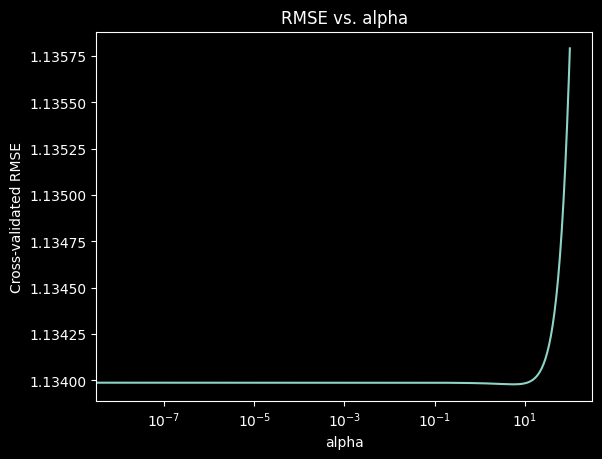

In [ ]:
rmses = []
for a in alphas:
    scores = cross_val_score(
        Ridge(alpha=a),
        X_meta,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    rmses.append(-scores.mean())

plt.figure()
plt.xscale("log")
plt.plot(alphas, rmses)
plt.xlabel("alpha")
plt.ylabel("Cross-validated RMSE")
plt.title("RMSE vs. alpha")
plt.show()

In [24]:
alphas[np.argmin(rmses)]

np.float64(5.463550352214865)

In [26]:
best_alpha = ridge_cv.alpha_
meta_final = Pipeline(
    steps=[
        ("sc", StandardScaler()),
        (
            "ridge",
            Ridge(
                alpha=best_alpha,
                random_state=SEED,
            ),
        ),
    ]
)

# full stacking model
stack_final = StackingRegressor(
    estimators=base_estimators,  # rf_pipeline, xgb_pipeline, ols_pipeline
    final_estimator=meta_final,
    cv=cv,  # same 10-fold KFold
    passthrough=False,
    n_jobs=-1,
)
stack_final.fit(X, y)

StackingRegressor(cv=KFold(n_splits=10, random_state=333, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('rf',
                                                RandomForestRegressor(ccp_alpha=1.2167748107168915e-06,
                                                                      criterion='absolute_error',
                                                                      max_features=11,
                                                                      max_samples=1.0,
                                                                      n_estimators=400,
                                                                      n_jobs=-1,
                                                                      oob_score=True,
                                                                      random_state=333))])),
                              ('xgb',
                               Pipeline(steps=[('xgb',
                                                XGBRegressor(base_score=None,
                                                             boo...
                                                             min_child_weight=4.106589606596879,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=750,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None, ...))])),
                              ('ols',
                               Pipeline(steps=[('sc', StandardScaler()),
                                               ('ols',
                                                LinearRegression(n_jobs=-1))]))],
                  final_estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                  ('ridge',
                                                   Ridge(alpha=np.float64(5.463550352214865),
                                                         random_state=333))]),
                  n_jobs=-1)